In [1]:
from random import randint
from numpy import array
from numpy import argmax
import keras.backend as K
from tensorflow.keras import models
from numpy import array_equal
import numpy as np
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Bidirectional, SimpleRNN, GRU
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras import Input
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from keras.optimizers import Adam

from tensorflow.keras.layers import Lambda
from tensorflow.keras import backend as K
import tensorflow as tf
import io

tf.keras.backend.set_floatx('float64')

In [2]:
!git clone https://github.com/borate267/lexicon-dataset.git

Cloning into 'lexicon-dataset'...
remote: Enumerating objects: 30, done.
remote: Counting objects: 100% (30/30), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 30 (delta 7), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (30/30), done.


In [3]:
!pip install wget

  Created wheel for wget: filename=wget-3.2-cp37-none-any.whl size=9681 sha256=59ef38572e416c6621e6ac6e15de48c552ec16b4c452b03ecd708cd7e7d1e140
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


In [4]:
import wget
wget.download('https://tamil.indiatyping.com/images/downloadfonts/Tamil/vijaya.zip')
!unzip /content/vijaya.zip

Archive:  /content/vijaya.zip
   creating: vijaya/
  inflating: vijaya/india typing.png  
  inflating: vijaya/read me.html     
  inflating: vijaya/vijaya.ttf       


In [5]:
from matplotlib.font_manager import FontProperties
tamil_font = FontProperties(fname = '/content/vijaya/vijaya.ttf') 

In [6]:
train_dir = "lexicon-dataset/ta.translit.sampled.train.tsv"
dev_dir = "lexicon-dataset/ta.translit.sampled.dev.tsv"
test_dir = "lexicon-dataset/ta.translit.sampled.test.tsv"

# The following function reads the raw text document and returns a list of lists comprising the romanized and native versions of the words

def read_corpus(corpus_file):
  tamil_words = []
  latin_words = []
  with io.open(corpus_file, encoding ='utf-8') as f:
    for line in f:
      if '\t' not in line:
        continue
      tokens = line.rstrip().split("\t")
      latin_words.append(tokens[1])
      tamil_words.append(tokens[0])
  return latin_words, tamil_words

train_source, train_target = read_corpus(train_dir)
valid_source, valid_target = read_corpus(dev_dir)
test_source, test_target = read_corpus(test_dir)

print("Number of training samples: ", len(train_source))
print("Number of validation samples: ", len(valid_source))
print("Number of testing samples: ", len(test_source))


Number of training samples:  68218
Number of validation samples:  6827
Number of testing samples:  6864


In [7]:
arr = np.arange(len(train_source))
np.random.shuffle(arr)
arr1 = np.arange(len(valid_source))
np.random.shuffle(arr1)

input_characters = set()
target_characters = set()
input_texts_ns = []
target_texts_ns = []
val_input_texts_ns = []
val_target_texts_ns = []

for (input_text, target_text) in zip(train_source, train_target):
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    target_text = "B" + target_text + "E"
    input_texts_ns.append(input_text)
    target_texts_ns.append(target_text)
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

for (input_text, target_text) in zip(valid_source, valid_target):
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    target_text = "B" + target_text + "E"
    val_input_texts_ns.append(input_text)
    val_target_texts_ns.append(target_text)
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

input_texts = []
target_texts = []

for i in range(len(train_source)):
    input_texts.append(input_texts_ns[arr[i]])
    target_texts.append(target_texts_ns[arr[i]])

val_input_texts = []
val_target_texts = []

for i in range(len(valid_source)):
    val_input_texts.append(val_input_texts_ns[arr1[i]])
    val_target_texts.append(val_target_texts_ns[arr1[i]])

input_characters.add(" ")
target_characters.add(" ")

input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))



# Adding the padding character
#input_characters.append("P")
#target_characters.append("P")

num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])
val_max_encoder_seq_length = max([len(txt) for txt in val_input_texts])
val_max_decoder_seq_length = max([len(txt) for txt in val_target_texts])



print("Number of samples:", len(input_texts))
print("Number of unique input tokens:", num_encoder_tokens)
print("Number of unique output tokens:", num_decoder_tokens)
print("Max sequence length for inputs:", max_encoder_seq_length)
print("Max sequence length for outputs:", max_decoder_seq_length)
print("Max sequence length for val inputs:", val_max_encoder_seq_length)
print("Max sequence length for val outputs:", val_max_decoder_seq_length)

print(input_characters)
print(target_characters)

Number of samples: 68218
Number of unique input tokens: 27
Number of unique output tokens: 49
Max sequence length for inputs: 30
Max sequence length for outputs: 28
Max sequence length for val inputs: 23
Max sequence length for val outputs: 22
[' ', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
[' ', 'B', 'E', 'ஃ', 'அ', 'ஆ', 'இ', 'ஈ', 'உ', 'ஊ', 'எ', 'ஏ', 'ஐ', 'ஒ', 'ஓ', 'க', 'ங', 'ச', 'ஜ', 'ஞ', 'ட', 'ண', 'த', 'ந', 'ன', 'ப', 'ம', 'ய', 'ர', 'ற', 'ல', 'ள', 'ழ', 'வ', 'ஷ', 'ஸ', 'ஹ', 'ா', 'ி', 'ீ', 'ு', 'ூ', 'ெ', 'ே', 'ை', 'ொ', 'ோ', 'ௌ', '்']


In [17]:
input_token_index = dict([(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict([(char, i) for i, char in enumerate(target_characters)])
reverse_source_char_index = dict((i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict((i, char) for char, i in target_token_index.items())
print(input_token_index)
print(target_token_index)

{' ': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26}
{' ': 0, 'B': 1, 'E': 2, 'ஃ': 3, 'அ': 4, 'ஆ': 5, 'இ': 6, 'ஈ': 7, 'உ': 8, 'ஊ': 9, 'எ': 10, 'ஏ': 11, 'ஐ': 12, 'ஒ': 13, 'ஓ': 14, 'க': 15, 'ங': 16, 'ச': 17, 'ஜ': 18, 'ஞ': 19, 'ட': 20, 'ண': 21, 'த': 22, 'ந': 23, 'ன': 24, 'ப': 25, 'ம': 26, 'ய': 27, 'ர': 28, 'ற': 29, 'ல': 30, 'ள': 31, 'ழ': 32, 'வ': 33, 'ஷ': 34, 'ஸ': 35, 'ஹ': 36, 'ா': 37, 'ி': 38, 'ீ': 39, 'ு': 40, 'ூ': 41, 'ெ': 42, 'ே': 43, 'ை': 44, 'ொ': 45, 'ோ': 46, 'ௌ': 47, '்': 48}


In [9]:
trunc_input_texts = input_texts[:68096]
trunc_target_texts = target_texts[:68096]

encoder_input_data = np.zeros(
    (len(trunc_input_texts), max_encoder_seq_length, num_encoder_tokens), dtype="float64"
)
decoder_target_data = np.zeros(
    (len(trunc_input_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float64"
)

for i, (input_text, target_text) in enumerate(zip(trunc_input_texts, trunc_target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.0
    encoder_input_data[i, t + 1 :, input_token_index[" "]] = 1.0
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_target_data[i, t, target_token_index[char]] = 1.0
    decoder_target_data[i, t + 1 :, target_token_index[" "]] = 1.0
    
val_encoder_input_data = np.zeros(
    (len(val_input_texts), max_encoder_seq_length, num_encoder_tokens), dtype="float64"
)
val_decoder_target_data = np.zeros(
    (len(val_target_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float64"
)

for i, (input_text, target_text) in enumerate(zip(val_input_texts, val_target_texts)):
    for t, char in enumerate(input_text):
        val_encoder_input_data[i, t, input_token_index[char]] = 1.0
    #encoder_input_data[i, t + 1 :] = input_token_index["P"]
    val_encoder_input_data[i, t + 1 :, input_token_index[" "]] = 1.0

    for t, char in enumerate(target_text):
      # decoder_target_data is ahead of decoder_input_data by one timestep
        val_decoder_target_data[i, t, target_token_index[char]] = 1.0
    val_decoder_target_data[i, t + 1: ,target_token_index[" "]] = 1.0
  


# ATTENTION MECHANISM 

In [10]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)
    
  def call(self, query, values):
    
    # query hidden state shape == (batch_size, hidden size)
    # query_with_time_axis shape == (batch_size, 1, hidden size)
    # values shape == (batch_size, max_len, hidden size)
    # we are doing this to broadcast addition along the time axis to calculate the score
    query_with_time_axis = tf.expand_dims(query, 1)
    
    
    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(query_with_time_axis) + self.W2(values)))
    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)
    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)
    return context_vector, attention_weights


In [11]:
#import tensorflow 
class LuongAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(LuongAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
   
    query_with_time_axis = tf.expand_dims(query, 1)
    
    values_transposed = tf.transpose(values, perm=[0, 2, 1])
    
    #LUONGH Dot-product
    score = tf.transpose(tf.matmul(query_with_time_axis, values_transposed) , perm=[0, 2, 1])

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)
    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [40]:
class MyRNN_atten(object):
  def __init__(self,cell_type = 'RNN', hidden_size=32, 
               learning_rate= 1e-3,dropout=0.3,epochs = 10, batch_size = 32,
               attention = 'bahdanau'):
    
    self.cell_type = cell_type
    self.hidden_size = hidden_size
    self.learning_rate = learning_rate
    self.dropout = dropout
    self.epochs = epochs
    self.batch_size = batch_size
    self.attention = attention

  def build_fit(self,encoder_input_data,decoder_target_data):

    encoder_inputs = Input(shape=(max_encoder_seq_length, num_encoder_tokens), name='encoder_inputs')
    if self.cell_type == 'LSTM':
      encoder_lstm = LSTM(self.hidden_size,return_sequences=True, return_state=True, dropout = self.dropout, name='encoder_lstm')
      encoder_outputs, encoder_state_h, encoder_state_c = encoder_lstm(encoder_inputs)
      encoder_states = [encoder_state_h, encoder_state_c]
    elif self.cell_type == 'GRU':
      encoder_gru = GRU(self.hidden_size,return_sequences=True, return_state=True, dropout = self.dropout, name='encoder_gru')
      encoder_outputs, encoder_state_h = encoder_gru(encoder_inputs)
      encoder_states = [encoder_state_h]
    elif self.cell_type == 'RNN':
      encoder_rnn = SimpleRNN(self.hidden_size,return_sequences=True, return_state=True, dropout = self.dropout, name='encoder_rnn')
      encoder_outputs, encoder_state_h = encoder_rnn(encoder_inputs)
      encoder_states = [encoder_state_h]

    # Set up the attention layer
    if self.attention == 'bahdanau':
      attention= BahdanauAttention(self.hidden_size)
    elif self.attention == 'luong':
      attention= LuongAttention(self.hidden_size)

    # Set up the decoder layers
    decoder_inputs = Input(shape=(1, (num_decoder_tokens+self.hidden_size)),name='decoder_inputs')
    if self.cell_type == 'LSTM':
      decoder_lstm = LSTM(self.hidden_size, dropout = self.dropout, return_state=True, name='decoder_lstm')
    elif self.cell_type == 'GRU':
      decoder_gru = GRU(self.hidden_size, dropout = self.dropout, return_state=True, name='decoder_gru')
    elif self.cell_type == 'RNN':
      decoder_rnn = SimpleRNN(self.hidden_size, dropout = self.dropout, return_state=True, name='decoder_rnn')  
    
    decoder_dense = Dense(num_decoder_tokens, activation='softmax',  name='decoder_dense')

    all_outputs = []

    inputs = np.zeros((self.batch_size, 1, num_decoder_tokens))
    inputs[:, 0, 0] = 1 

    decoder_outputs = encoder_state_h
    states = encoder_states

    for _ in range(max_decoder_seq_length):

      context_vector, attention_weights=attention(decoder_outputs, encoder_outputs)
      
      context_vector = tf.expand_dims(context_vector, 1)
      
      inputs = tf.concat([context_vector, inputs], axis=-1)
      if self.cell_type == 'LSTM':
        decoder_outputs, state_h, state_c = decoder_lstm(inputs, initial_state=states)
      if self.cell_type == 'GRU':
        decoder_outputs, state_h = decoder_gru(inputs, initial_state=states)
      if self.cell_type == 'RNN':
        decoder_outputs, state_h = decoder_rnn(inputs, initial_state=states)
      
      outputs = decoder_dense(decoder_outputs)
      outputs = tf.expand_dims(outputs, 1)
      all_outputs.append(outputs)
      inputs = outputs
      if self.cell_type == 'LSTM':
        states = [state_h, state_c]
      if self.cell_type == 'GRU' or self.cell_type == 'RNN':
        states = [state_h]


    decoder_outputs = Lambda(lambda x: K.concatenate(x, axis=1))(all_outputs)
    #getindicelayer = Lambda(lambda x: x[:, -1, :]) 
    #decoder_outputs = getindicelayer(all_outputs)

    model = Model(encoder_inputs, decoder_outputs, name='model_encoder_decoder')
    
    optimizer = Adam(lr=self.learning_rate, beta_1=0.9, beta_2=0.999)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    #model.summary()

    model.fit(encoder_input_data, decoder_target_data,
              batch_size=self.batch_size, 
              epochs=self.epochs,
              )
    if self.cell_type == 'LSTM':
      return encoder_lstm,attention,decoder_lstm,decoder_dense
    if self.cell_type == 'GRU':
      return encoder_gru,attention,decoder_gru,decoder_dense
    if self.cell_type == 'RNN':
      return encoder_rnn,attention,decoder_rnn,decoder_dense  
    
  def evaluate(self,seq_in):
    attention_plot = np.zeros((max_decoder_seq_length, max_encoder_seq_length))
    #sequence = [7, 9, 8, 5]
    sequence = seq_in
    #sequence = one_hot_encode(seq_in,num_encoder_tokens)
    encoder_inputs=array(sequence).reshape(1,max_encoder_seq_length,num_encoder_tokens)
    
    encoder_inputs = tf.convert_to_tensor(encoder_inputs,dtype=tf.float32)
    
    if self.cell_type == 'LSTM':
      #encoder_lstm = LSTM(self.hidden_size,return_sequences=True, return_state=True, dropout = self.dropout, name='encoder_lstm')
      encoder_outputs, encoder_state_h, encoder_state_c = encoder(encoder_inputs)
      encoder_states = [encoder_state_h, encoder_state_c]
    elif self.cell_type == 'GRU':
      #encoder_gru = GRU(self.hidden_size,return_sequences=True, return_state=True, dropout = self.dropout, name='encoder_gru')
      encoder_outputs, encoder_state_h = encoder(encoder_inputs)
      encoder_states = [encoder_state_h]
    elif self.cell_type == 'RNN':
      #encoder_rnn = SimpleRNN(self.hidden_size,return_sequences=True, return_state=True, dropout = self.dropout, name='encoder_rnn')
      encoder_outputs, encoder_state_h = encoder(encoder_inputs)
      encoder_states = [encoder_state_h]

    all_outputs = []

    decoder_input_data = np.zeros((1, 1, num_decoder_tokens))
    decoder_input_data[:, 0, 0] = 1 

    inputs = decoder_input_data
    decoder_outputs = encoder_state_h
    states = encoder_states

    for t in range(max_decoder_seq_length):

      # pay attention
      context_vector, attention_weights=attention(decoder_outputs, encoder_outputs)

      # storing the attention weights to plot later on
      attention_weights = tf.reshape(attention_weights, (-1, ))
      attention_plot[t] = attention_weights.numpy()
      
      decoder_outputs=tf.expand_dims(decoder_outputs, 1)

      context_vector = tf.expand_dims(context_vector, 1)
      inputs = tf.concat([context_vector, inputs], axis=-1)

      if self.cell_type == 'LSTM':
        decoder_outputs, state_h, state_c = decoder(inputs, initial_state=states)
      if self.cell_type == 'GRU':
        decoder_outputs, state_h = decoder(inputs, initial_state=states)
      if self.cell_type == 'RNN':
        decoder_outputs, state_h = decoder(inputs, initial_state=states)
            
      outputs = decoder_dense(decoder_outputs)
      # Store the current prediction (we will concatenate all predictions later)
      outputs = tf.expand_dims(outputs, 1)
      all_outputs.append(outputs)
      inputs = outputs
      if self.cell_type == 'LSTM':
        states = [state_h, state_c]
      if self.cell_type == 'GRU' or self.cell_type == 'RNN':
        states = [state_h]
    
    decoder_outputs = Lambda(lambda x: K.concatenate(x, axis=1))(all_outputs)
    seq_outs = decoder_outputs[0]
    seq_out = tf.argmax(seq_outs, axis=1)
    seq_out = seq_out.numpy()
    seq_in = tf.argmax(seq_in, axis = 1)
    seq_in = seq_in.numpy()
    list(filter(lambda num: num != 0, seq_in))
    list(filter(lambda num: num != 0, seq_out))
    
    return seq_in, seq_out, attention_plot

  def plot_attention(self,attention, sequence, predicted_sequence):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}
    seq = ''
    for i in range(len(sequence)):
      seq = seq + reverse_source_char_index[sequence[i]]
    
    pred = ''
    for i in range(len(predicted_sequence)):
      pred = pred + reverse_target_char_index[predicted_sequence[i]]

    #ax.rcParams["font.family"] = "Vijaya"
    ax.set_xticklabels(seq, fontdict=fontdict)
    ax.set_yticklabels(pred, fontdict=fontdict, fontproperties = tamil_font)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

  def translate(self,seq_in):
    seq_in, seq_out, attention_plot = self.evaluate(seq_in)

    a = [0]
    for i in range(len(seq_in)):
      if seq_in[i] != 0:
        a.append(seq_in[i])

    b = []
    for i in range(len(seq_out)):
      if seq_out[i] != 0:
        b.append(seq_out[i])
  
    b = b[:len(b)-1]
    print(a)
    print(b)
    
    attention_plot = attention_plot[:len(b), :len(a)]
    self.plot_attention(attention_plot, a, b)  

  def attention_plot(self,val_input):
    for i in range(1,10,1):
      seq_in = val_input[i]
      self.translate(seq_in)  

In [41]:
model_rnn = MyRNN_atten(cell_type = 'LSTM', hidden_size=128, learning_rate= 1e-3,
                        dropout=0.2,epochs = 10, batch_size = 128, attention = 'luong')

In [38]:
encoder,attention,decoder,decoder_dense = model_rnn.build_fit(encoder_input_data,decoder_target_data)

Epoch 1/10
532/532 [==============================] - 74s 83ms/step - loss: 1.4075 - accuracy: 0.6653
Epoch 2/10
532/532 [==============================] - 44s 82ms/step - loss: 1.0277 - accuracy: 0.6989
Epoch 3/10
532/532 [==============================] - 43s 82ms/step - loss: 0.9475 - accuracy: 0.7128
Epoch 4/10
532/532 [==============================] - 43s 80ms/step - loss: 0.8549 - accuracy: 0.7329
Epoch 5/10
532/532 [==============================] - 43s 80ms/step - loss: 0.7684 - accuracy: 0.7554
Epoch 6/10
532/532 [==============================] - 43s 80ms/step - loss: 0.6942 - accuracy: 0.7790
Epoch 7/10
532/532 [==============================] - 43s 80ms/step - loss: 0.6377 - accuracy: 0.7986
Epoch 8/10
532/532 [==============================] - 43s 80ms/step - loss: 0.6023 - accuracy: 0.8115
Epoch 9/10
532/532 [==============================] - 43s 80ms/step - loss: 0.5726 - accuracy: 0.8226
Epoch 10/10
532/532 [==============================] - 43s 80ms/step - loss: 0.547

[0, 9, 1, 3, 3]
[1, 12, 15, 48, 48, 48]


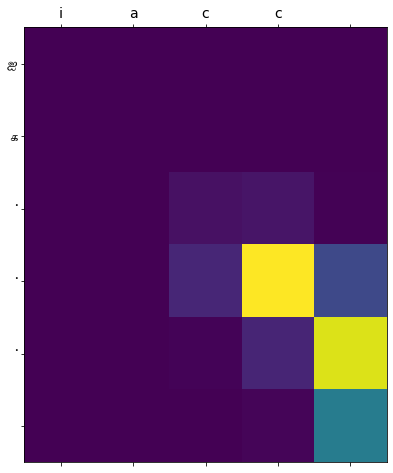

[0, 11, 1, 20, 20, 1, 20, 20, 1, 9]
[1, 15, 20, 48, 20, 22, 48]


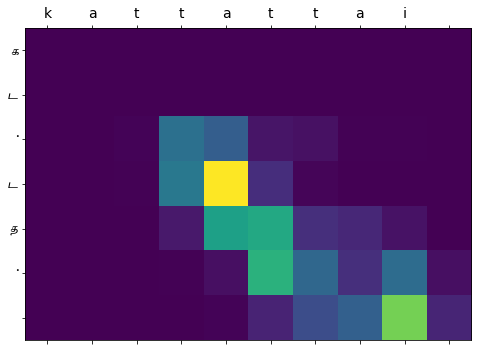

[0, 11, 21, 18, 1, 22, 1, 14, 10, 3, 8, 9]
[1, 15, 40, 28, 37, 48, 48, 17, 38]


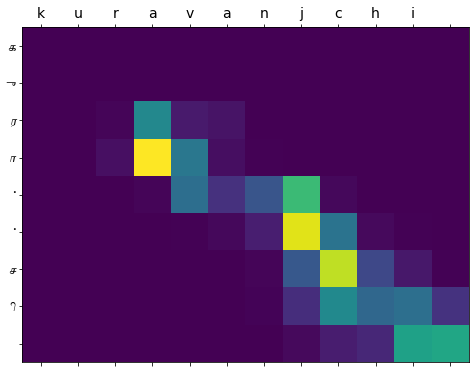

[0, 11, 1, 1, 16, 16, 1, 1, 20, 18, 9, 14, 1, 1, 18]
[1, 15, 37, 25, 48, 25, 37, 29, 48, 29, 38, 24, 28]


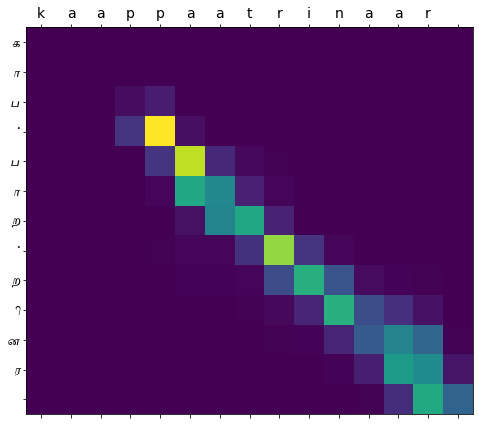

[0, 8, 1, 1, 18, 9, 19, 1, 14]
[1, 36, 37, 28, 38, 24, 48]


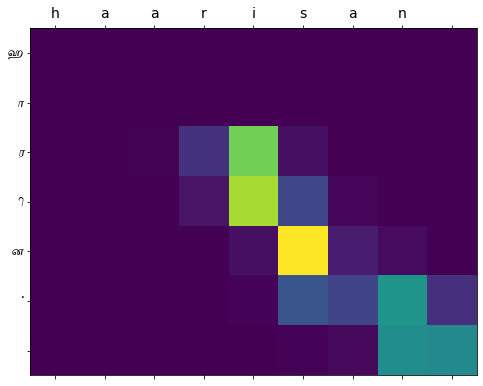

[0, 11, 1, 14, 1, 11, 1, 20, 8, 20, 8, 9, 14]
[1, 15, 21, 15, 22, 48, 22, 38, 24, 48]


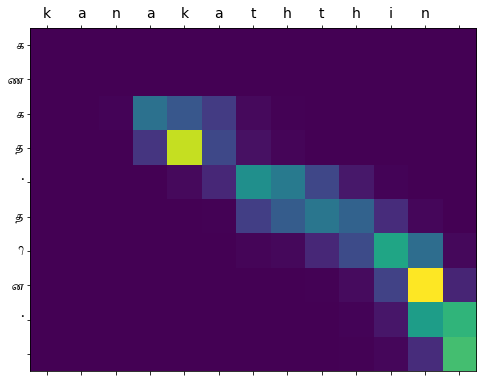

[0, 16, 15, 1, 20, 20, 9, 25, 9, 12, 9, 18, 21, 14, 20, 8, 21]
[1, 25, 46, 20, 48, 20, 38, 27, 38, 30, 40, 28, 48, 23, 48, 22]


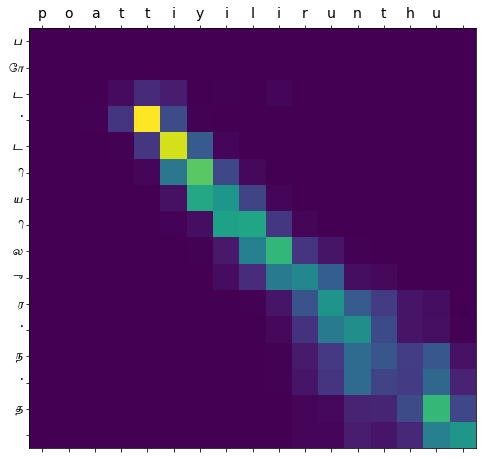

[0, 11, 15, 22, 20, 8, 1, 13]
[1, 15, 45, 22, 48, 26, 26]


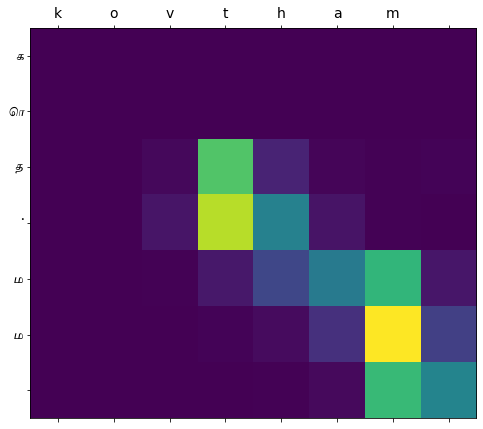

[0, 22, 5, 5, 12, 3, 8, 3, 8, 9, 25, 1, 1, 12]
[1, 33, 42, 31, 48, 17, 48, 17, 38, 27, 37, 30]


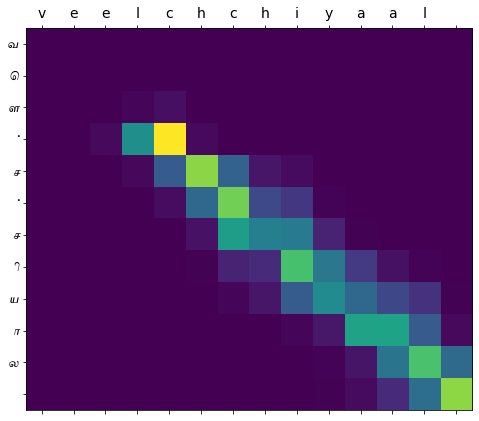

In [42]:
model_rnn.attention_plot(val_encoder_input_data)